In [1]:
#Set different parameter choices
sigma = [.02, .04, .06]
b = [.04, .06]
t = [1/12]
a = [1, .5, .25]

In [2]:
import itertools
import numpy as np
params = np.array(list(itertools.product(*(sigma, b, t, a))))
print(params)

[[0.02       0.04       0.08333333 1.        ]
 [0.02       0.04       0.08333333 0.5       ]
 [0.02       0.04       0.08333333 0.25      ]
 [0.02       0.06       0.08333333 1.        ]
 [0.02       0.06       0.08333333 0.5       ]
 [0.02       0.06       0.08333333 0.25      ]
 [0.04       0.04       0.08333333 1.        ]
 [0.04       0.04       0.08333333 0.5       ]
 [0.04       0.04       0.08333333 0.25      ]
 [0.04       0.06       0.08333333 1.        ]
 [0.04       0.06       0.08333333 0.5       ]
 [0.04       0.06       0.08333333 0.25      ]
 [0.06       0.04       0.08333333 1.        ]
 [0.06       0.04       0.08333333 0.5       ]
 [0.06       0.04       0.08333333 0.25      ]
 [0.06       0.06       0.08333333 1.        ]
 [0.06       0.06       0.08333333 0.5       ]
 [0.06       0.06       0.08333333 0.25      ]]


In [3]:
sigma = list(params[:,0])
b = list(params[:,1])
t = list(params[:,2])
a = list(params[:,3])

In [4]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import pandas as pd
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD import configs

#Set an initial interest rate
initial_state = {'r': .08}


#Basic vasicek rate change model
def rate_change(r, a=.5, b=.06, sigma=.04, t=1/12):
    delta = a* (b-r) * t + t ** .5 * sigma * t ** .5 * norm.ppf(np.random.RandomState().rand())
    return delta + r


#Policy for updating
def vasicek_policy(_params, substep, sH, s):
    r = rate_change(s['r'], _params['a'], _params['b'], _params['sigma'], _params['t'])
    return {'r': r}

#Simple state update
def update_rate(_params, substep, sH, s, _input):
    return ('r', _input['r'])

#Partial updates
PSUBs = [
    {
        "policies": {
            "rate_policy": vasicek_policy,
        },
        "variables": {
            "r": update_rate,
        }
    }
]

#Set simulation parameters

#The M parameter will let us test different combinations of parameters
sim_config_dict = {
    'T': range(360),
    'N': 100,
"M": {'a': a, 'b':b, 'sigma':sigma, 't':t}}

c = config_sim(sim_config_dict)


exp = Experiment()
exp.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = PSUBs,
    sim_configs = c
)


exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.single_mode)

simulation = Executor(exec_context=local_mode_ctx, configs=configs)
raw_result, field, sessions = simulation.execute()
result = pd.DataFrame(raw_result)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: single_proc
Configuration Count: 18
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (360, 4, 100, 1)
Execution Method: parallelize_simulations
SimIDs   : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2

Total execution time: 341.67s


In [5]:
mu = result.groupby(['timestep', 'simulation'])['r'].mean().unstack()
print(mu)

simulation        0         1         2         3         4         5   \
timestep                                                                 
0           0.080000  0.080000  0.080000  0.080000  0.080000  0.080000   
1           0.076521  0.078208  0.079227  0.078234  0.079266  0.079650   
2           0.073640  0.076380  0.078265  0.076749  0.078613  0.079061   
3           0.070782  0.074516  0.077660  0.075345  0.077767  0.078471   
4           0.068301  0.072903  0.076991  0.073905  0.077163  0.078198   
...              ...       ...       ...       ...       ...       ...   
356         0.040420  0.039955  0.038520  0.060588  0.059944  0.059713   
357         0.040384  0.040135  0.038544  0.060296  0.059946  0.059644   
358         0.040124  0.040386  0.038514  0.060146  0.060008  0.059361   
359         0.040262  0.040343  0.038544  0.060151  0.059908  0.059342   
360         0.040269  0.040351  0.038618  0.059947  0.060158  0.059377   

simulation        6         7        

In [6]:
params = pd.DataFrame(list(zip(sigma, b, t, a)), columns = ['sigma', 'b', 't', 'a'])

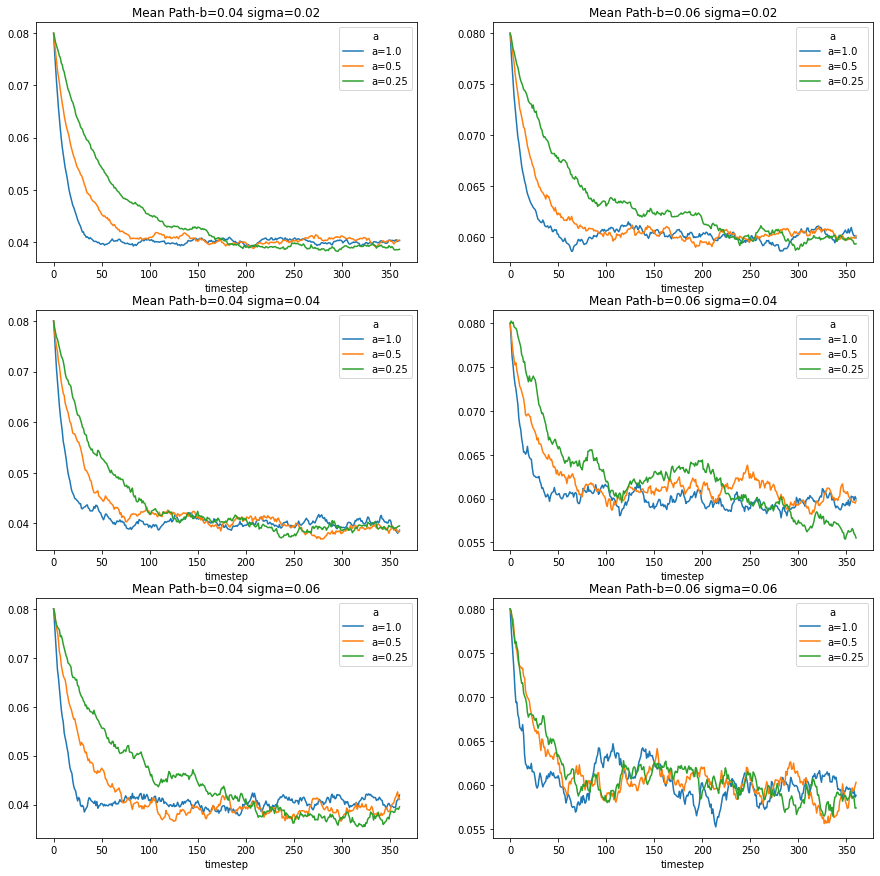

In [7]:
fig, ax = plt.subplots(nrows=len(params['sigma'].unique()),
                      ncols=len(params['b'].unique()),
                      figsize=(15,15))

for i1, sigma in enumerate(params['sigma'].unique()):
    for i2, b in enumerate(params['b'].unique()):
        ax[i1,i2].set_title("Mean Path-b={} sigma={}".format(b,sigma))
        ts = mu[params[(params['sigma'] == sigma) & (params['b'] == b)].index]
        ts.columns = params[(params['sigma'] == sigma) & (params['b'] == b)]['a']
        ts.columns = "a="+ts.columns.astype(str)
        ts.plot(ax=ax[i1,i2])
plt.show()

In [8]:
std_cross_section = result.groupby(['timestep', 'simulation'])['r'].std().unstack()
print(std_cross_section)

simulation        0         1         2         3         4         5   \
timestep                                                                 
0           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1           0.001709  0.001723  0.001566  0.001593  0.001796  0.001627   
2           0.002234  0.002431  0.002257  0.002309  0.002327  0.002325   
3           0.002364  0.002649  0.003130  0.002542  0.002889  0.002906   
4           0.002697  0.003289  0.003471  0.002848  0.003372  0.003406   
...              ...       ...       ...       ...       ...       ...   
356         0.004011  0.005973  0.008436  0.004432  0.006472  0.008745   
357         0.003955  0.005814  0.008201  0.004658  0.006332  0.008643   
358         0.003664  0.005677  0.008016  0.004688  0.006100  0.008732   
359         0.004031  0.005640  0.008210  0.004444  0.006012  0.008437   
360         0.004103  0.005791  0.008244  0.004162  0.006077  0.008454   

simulation        6         7        

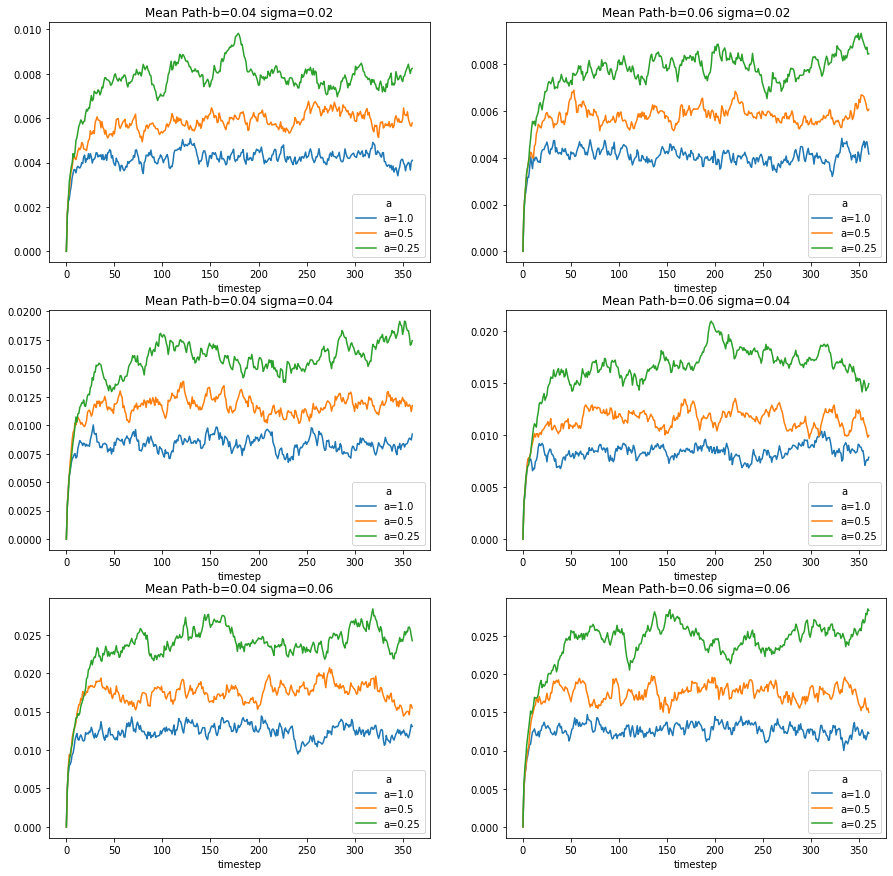

In [9]:
fig, ax = plt.subplots(nrows=len(params['sigma'].unique()),
                      ncols=len(params['b'].unique()),
                      figsize=(15,15))

for i1, sigma in enumerate(params['sigma'].unique()):
    for i2, b in enumerate(params['b'].unique()):
        ax[i1,i2].set_title("Mean Path-b={} sigma={}".format(b,sigma))
        ts = std_cross_section[params[(params['sigma'] == sigma) & (params['b'] == b)].index]
        ts.columns = params[(params['sigma'] == sigma) & (params['b'] == b)]['a']
        ts.columns = "a="+ts.columns.astype(str)
        ts.plot(ax=ax[i1,i2])
plt.show()

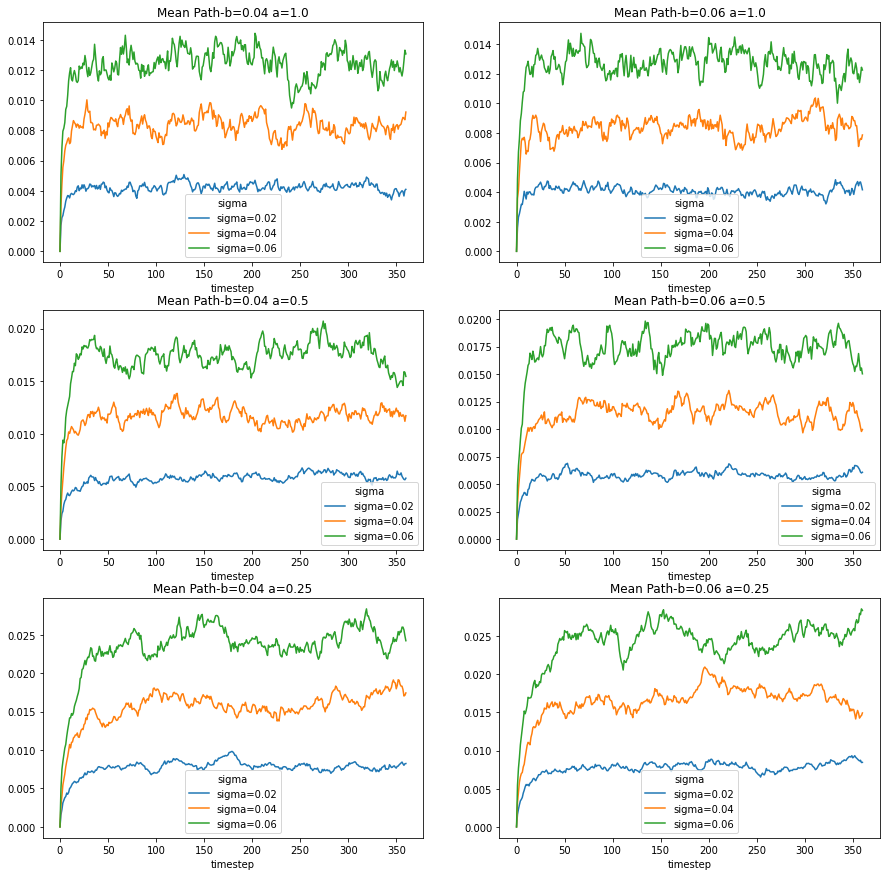

In [10]:
fig, ax = plt.subplots(nrows=len(params['a'].unique()),
                      ncols=len(params['b'].unique()),
                      figsize=(15,15))

for i1, a in enumerate(params['a'].unique()):
    for i2, b in enumerate(params['b'].unique()):
        ax[i1,i2].set_title("Mean Path-b={} a={}".format(b,a))
        ts = std_cross_section[params[(params['a'] == a) & (params['b'] == b)].index]
        ts.columns = params[(params['a'] == a) & (params['b'] == b)]['sigma']
        ts.columns = "sigma="+ts.columns.astype(str)
        ts.plot(ax=ax[i1,i2])
plt.show()